MACHINE LEARNING PRACTICAL: COURSEWORK 4

In [1]:
#####################################################################
# 1) Imports & Basic Environment Checks
#####################################################################
print("GPU Info:")
gpu_info = !nvidia-smi
print("\n".join(gpu_info))

GPU Info:
Thu Mar 27 22:45:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-------------------------------------

In [ ]:
#####################################################################
# 2) Mount Google Drive
#####################################################################
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#####################################################################
# 0) Installs libraries (not already installed in Colab)
#####################################################################
!pip install SimpleITK
!pip install torchio
!pip install segmentation-models-pytorch

In [ ]:
# ==================== Imports ====================
import os
import random
import tarfile
import numpy as np
import cv2
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import shutil
import SimpleITK as sitk
import random
import torchio as tio
from psutil import virtual_memory

In [ ]:
#####################################################################
# 3) Configuration Toggles & Parameters
#####################################################################
TARGET_SPACING = (1.0, 1.0, 1.0)  # Adjust if heavy interpolation is undesirable
WINDOW_INTENSITIES = True        # Toggle to clamp CT intensities to [HU_LOW, HU_HIGH]
HU_LOW, HU_HIGH = -100, 400      # Example window for abdominal CT
DO_LABEL_SWAP = False            # Set True if you really need to swap label IDs
SWAP_MAP = {1: 2, 2: 1}          # e.g. 1 ↔ 2
DEBUG_PRINT = True               # Print metadata info for debugging


raw_tar_path = "/content/drive/MyDrive/Task08_HepaticVessel.tar"
extraction_dir = "Task08_HepaticVessel"


In [ ]:
#####################################################################
# 4) Helpful Print/Debug Functions
#####################################################################
def print_image_info(image, title=""):
    """ Print metadata (spacing, origin, direction) for debugging. """
    if not DEBUG_PRINT:
        return
    spacing = image.GetSpacing()
    origin = image.GetOrigin()
    direction = image.GetDirection()
    size = image.GetSize()
    print(f"\n--- {title} ---")
    print(f"Size (xyz):    {size}")
    print(f"Spacing (xyz): {spacing}")
    print(f"Origin (xyz):  {origin}")
    print(f"Direction:     {direction}")

In [ ]:
#####################################################################
# 5) Preprocessing Functions
#####################################################################
def standardize_orientation(image):
    """Convert to RAS orientation."""
    return sitk.DICOMOrient(image, 'RAS')

def window_intensity(image, low=HU_LOW, high=HU_HIGH):
    """Clamp intensities to [low, high]."""
    array = sitk.GetArrayFromImage(image).astype(np.float32)
    array = np.clip(array, low, high)
    out_img = sitk.GetImageFromArray(array)
    out_img.CopyInformation(image)
    return out_img

def resample_image(image, target_spacing, interp):
    """Resample to new spacing (xyz)."""
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [
        int(np.round(original_size[i] * (original_spacing[i] / target_spacing[i])))
        for i in range(3)
    ]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(target_spacing)
    resample.SetSize(new_size)
    resample.SetInterpolator(interp)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    return resample.Execute(image)

def normalize_intensity_zscore(image):
    """Per-volume Z-score normalization."""
    array = sitk.GetArrayFromImage(image).astype(np.float32)
    mean, std = np.mean(array), np.std(array)
    if std < 1e-6:
        std = 1e-6
    norm_array = (array - mean) / std
    out_img = sitk.GetImageFromArray(norm_array)
    out_img.CopyInformation(image)
    return out_img

def preprocess_image(image_path, output_path):
    """Preprocess a CT image: orientation -> optional window -> resample -> normalize."""
    image = sitk.ReadImage(image_path)
    print_image_info(image, title=f"Original Image: {os.path.basename(image_path)}")

    image = standardize_orientation(image)

    if WINDOW_INTENSITIES:
        image = window_intensity(image, HU_LOW, HU_HIGH)

    image = resample_image(image, TARGET_SPACING, interp=sitk.sitkBSpline)
    image = normalize_intensity_zscore(image)

    print_image_info(image, title="Preprocessed Image")
    sitk.WriteImage(image, output_path)
    print(f"Processed image saved: {output_path}\n")

def preprocess_label(label_path, output_path):
    """Preprocess a label: orientation -> nearest-neighbor resample -> optional ID swap."""
    label = sitk.ReadImage(label_path)
    print_image_info(label, title=f"Original Label: {os.path.basename(label_path)}")

    label = standardize_orientation(label)
    label = resample_image(label, TARGET_SPACING, interp=sitk.sitkNearestNeighbor)

    # If needed, swap IDs
    if DO_LABEL_SWAP:
        arr = sitk.GetArrayFromImage(label)
        new_arr = np.zeros_like(arr)
        for old_val, new_val in SWAP_MAP.items():
            new_arr[arr == old_val] = new_val
        label = sitk.GetImageFromArray(new_arr)
        label.CopyInformation(label)  # preserve metadata

    print_image_info(label, title="Preprocessed Label")
    sitk.WriteImage(label, output_path)
    print(f"Processed label saved: {output_path}\n")

In [ ]:
# 6.1 - Extract Data (if needed)
if os.path.exists(raw_tar_path):
    with tarfile.open(raw_tar_path, 'r') as tar:
        tar.extractall(path=".")
    print(f"Extracted data to: {extraction_dir}")
else:
    print("No .tar file found. Skipping extraction.")

# 6.2 - Remove Hidden/Extra Files
def remove_extra_files(folder):
    if not os.path.exists(folder):
        return
    for file_ in os.listdir(folder):
        if file_.startswith(".") or file_.startswith("._"):
            path_ = os.path.join(folder, file_)
            if os.path.isdir(path_):
                shutil.rmtree(path_)
            else:
                os.remove(path_)

img_folder = os.path.join(extraction_dir, "imagesTr")
lbl_folder = os.path.join(extraction_dir, "labelsTr")
remove_extra_files(img_folder)
remove_extra_files(lbl_folder)


In [ ]:
# 6.3 - Check Matching Filenames
def check_matching_files(image_folder, label_folder):
    img_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".nii.gz")])
    lbl_files = sorted([f for f in os.listdir(label_folder) if f.endswith(".nii.gz")])
    if len(img_files) != len(lbl_files):
        print(f"WARNING: {len(img_files)} images vs {len(lbl_files)} labels.")
    else:
        print("Images & labels count is consistent.")

    for im, lb in zip(img_files, lbl_files):
        if im.split('.')[0] != lb.split('.')[0]:
            print(f"Filename mismatch: {im} vs {lb}")
    return img_files, lbl_files

image_files, label_files = check_matching_files(img_folder, lbl_folder)

# 6.4 - Preprocessing the Entire Set
preproc_img_dir = os.path.join(extraction_dir, "Preprocessed_images")
preproc_lbl_dir = os.path.join(extraction_dir, "Preprocessed_labels")
os.makedirs(preproc_img_dir, exist_ok=True)
os.makedirs(preproc_lbl_dir, exist_ok=True)

print("\nStarting preprocessing of images & labels...")
for f in image_files:
    ipath = os.path.join(img_folder, f)
    opath = os.path.join(preproc_img_dir, f)
    preprocess_image(ipath, opath)

for f in label_files:
    ipath = os.path.join(lbl_folder, f)
    opath = os.path.join(preproc_lbl_dir, f)
    preprocess_label(ipath, opath)
print("\nPreprocessing complete!")

In [ ]:
#####################################################################
# 7) Splitting into Train/Val
#####################################################################
split_dir = os.path.join(extraction_dir, "split_dataset")
train_img_dir = os.path.join(split_dir, "train", "images")
train_lbl_dir = os.path.join(split_dir, "train", "labels")
val_img_dir   = os.path.join(split_dir, "val",   "images")
val_lbl_dir   = os.path.join(split_dir, "val",   "labels")

for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

preproc_images = sorted([f for f in os.listdir(preproc_img_dir) if f.endswith(".nii.gz")])
preproc_labels = sorted([f for f in os.listdir(preproc_lbl_dir) if f.endswith(".nii.gz")])

all_pairs = list(zip(preproc_images, preproc_labels))
random.seed(42)
random.shuffle(all_pairs)
split_ratio = 0.85
split_idx = int(split_ratio * len(all_pairs))
train_pairs = all_pairs[:split_idx]
val_pairs   = all_pairs[split_idx:]
print(f"Total samples: {len(all_pairs)} | Train: {len(train_pairs)} | Val: {len(val_pairs)}")

# Copy to respective folders
for (imgf, lblf) in train_pairs:
    shutil.copy(os.path.join(preproc_img_dir,  imgf), os.path.join(train_img_dir, imgf))
    shutil.copy(os.path.join(preproc_lbl_dir, lblf), os.path.join(train_lbl_dir, lblf))

for (imgf, lblf) in val_pairs:
    shutil.copy(os.path.join(preproc_img_dir,  imgf), os.path.join(val_img_dir, imgf))
    shutil.copy(os.path.join(preproc_lbl_dir, lblf), os.path.join(val_lbl_dir, lblf))

print("Train/Val split done!")

In [ ]:
#####################################################################
# 8)Archive the Final Split to Drive
#####################################################################
archive_name = "split_dataset"
shutil.make_archive(archive_name, 'tar', root_dir=split_dir)
dest_path = os.path.join("/content/drive/MyDrive", f"{archive_name}.tar")
shutil.move(f"{archive_name}.tar", dest_path)
print(f"Archived dataset saved to: {dest_path}")

In [ ]:
#####################################################################
# 9) Quick Visualization of a Random Sample
#####################################################################
def visualize_sample(image_path, label_path, slice_idx=None):
    image = sitk.ReadImage(image_path)
    label = sitk.ReadImage(label_path)
    img_np = sitk.GetArrayFromImage(image)
    lbl_np = sitk.GetArrayFromImage(label)

    if slice_idx is None:
        slice_idx = img_np.shape[0] // 2

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(img_np[slice_idx], cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(img_np[slice_idx], cmap='gray')
    ax[1].imshow(lbl_np[slice_idx], alpha=0.5)
    ax[1].set_title("Overlay (Label)")
    plt.show()

# Example: visualize the first training sample
train_imgs = sorted(os.listdir(train_img_dir))
train_lbls = sorted(os.listdir(train_lbl_dir))
if len(train_imgs) > 0:
    sample_image_path = os.path.join(train_img_dir, train_imgs[0])
    sample_label_path = os.path.join(train_lbl_dir, train_lbls[0])
    visualize_sample(sample_image_path, sample_label_path, slice_idx=50)

print("All Done! Colab+Drive preprocessing pipeline complete.")

In [ ]:
import os
import tarfile

# Path to the archived dataset tar file in Drive
tar_path = "/content/drive/MyDrive/split_dataset.tar"

# Choose where you want to extract it on Drive
extract_path = "/content/drive/MyDrive/extracted_split_dataset"
os.makedirs(extract_path, exist_ok=True)

# Extract
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)

print(f"Extraction complete! Dataset is now in: {extract_path}")


In [ ]:
def visualize_image_and_label(image_path, label_path, slice_idx=None):
    """
    Loads a 3D .nii.gz image and its corresponding label,
    then displays a single slice for both side-by-side.
    """
    # Read with SimpleITK
    image_itk = sitk.ReadImage(image_path)
    label_itk = sitk.ReadImage(label_path)

    # Convert to numpy arrays: shape (D, H, W)
    image_np = sitk.GetArrayFromImage(image_itk)
    label_np = sitk.GetArrayFromImage(label_itk)

    # Default to the middle slice if none is provided
    if slice_idx is None:
        slice_idx = image_np.shape[0] // 2

    print(f"Visualizing slice {slice_idx} of {os.path.basename(image_path)}")
    print(f"Image shape: {image_np.shape} | Label shape: {label_np.shape}")

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left: the raw image
    axes[0].imshow(image_np[slice_idx], cmap='gray')
    axes[0].set_title("Image Slice")

    # Right: overlay label on the same slice
    axes[1].imshow(image_np[slice_idx], cmap='gray')
    axes[1].imshow(label_np[slice_idx], cmap='jet', alpha=0.4)
    axes[1].set_title("Image + Label Overlay")

    plt.show()


extracted_base = "/content/drive/MyDrive/extracted_split_dataset"

train_img_dir = os.path.join(extracted_base, "train", "images")
train_lbl_dir = os.path.join(extracted_base, "train", "labels")

# List all .nii.gz files
train_imgs = sorted([f for f in os.listdir(train_img_dir) if f.endswith(".nii.gz")])
train_lbls = sorted([f for f in os.listdir(train_lbl_dir) if f.endswith(".nii.gz")])

if len(train_imgs) != len(train_lbls):
    print(f"Warning: #images={len(train_imgs)} vs #labels={len(train_lbls)}.")
else:
    print(f"Found {len(train_imgs)} image/label pairs.")

# Pick a random pair
random_idx = random.randint(0, len(train_imgs) - 1)
img_file = train_imgs[random_idx]
lbl_file = train_lbls[random_idx]

img_path = os.path.join(train_img_dir, img_file)
lbl_path = os.path.join(train_lbl_dir, lbl_file)

# Visualize
visualize_image_and_label(img_path, lbl_path, slice_idx=50)  # or any slice index you want

In [ ]:
###############################################################################
#  A) Pad-or-Crop Function
###############################################################################
def pad_or_crop_to_shape(sitk_image, target_shape=(256,256,256)):
    array = sitk.GetArrayFromImage(sitk_image)  # (D,H,W)
    dd, hh, ww = array.shape
    TD, TH, TW = target_shape

    out_array = np.zeros((TD, TH, TW), dtype=array.dtype)

    def center_slice_for_target(orig_size, new_size):
        start = max((new_size - orig_size)//2, 0)
        end = start + min(orig_size, new_size)
        return slice(start, end)

    def center_slice_for_orig(orig_size, new_size):
        start = max((orig_size - new_size)//2, 0)
        end = start + min(orig_size, new_size)
        return slice(start, end)

    # Destination slices
    dstD = center_slice_for_target(dd, TD)
    dstH = center_slice_for_target(hh, TH)
    dstW = center_slice_for_target(ww, TW)

    # Source slices
    srcD = center_slice_for_orig(dd, TD)
    srcH = center_slice_for_orig(hh, TH)
    srcW = center_slice_for_orig(ww, TW)

    out_array[dstD, dstH, dstW] = array[srcD, srcH, srcW]

    out_sitk = sitk.GetImageFromArray(out_array)
    out_sitk.SetSpacing(sitk_image.GetSpacing())
    out_sitk.SetDirection(sitk_image.GetDirection())
    out_sitk.SetOrigin(sitk_image.GetOrigin())
    return out_sitk

In [ ]:
###############################################################################
#  B) Function to Remove Leading/Trailing Spaces in Filenames
###############################################################################
def clean_filenames(folder):
    """
    For every file in `folder`,
    1) If the filename has leading/trailing spaces, rename it to a stripped version.
    2) Optionally could fix other hidden chars, but this is a minimal approach.
    """
    for fname in os.listdir(folder):
        original_path = os.path.join(folder, fname)
        # Skip subfolders or non-file items if any
        if not os.path.isfile(original_path):
            continue
        clean_name = fname.strip()  # remove leading/trailing whitespace
        # If the stripped name differs, renames
        if clean_name != fname:
            new_path = os.path.join(folder, clean_name)
            print(f"Renaming:\n  '{fname}' -> '{clean_name}'")
            os.rename(original_path, new_path)

In [ ]:
# Path to your split dataset
split_dataset_dir = "/content/drive/MyDrive/extracted_split_dataset"

train_img_dir = os.path.join(split_dataset_dir, "train", "images")
train_lbl_dir = os.path.join(split_dataset_dir, "train", "labels")
val_img_dir   = os.path.join(split_dataset_dir, "val", "images")
val_lbl_dir   = os.path.join(split_dataset_dir, "val", "labels")

# Path to store the resized version
resized_root = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset"
resized_train_img_dir = os.path.join(resized_root, "train", "images")
resized_train_lbl_dir = os.path.join(resized_root, "train", "labels")
resized_val_img_dir   = os.path.join(resized_root, "val",   "images")
resized_val_lbl_dir   = os.path.join(resized_root, "val",   "labels")

for d in [resized_train_img_dir, resized_train_lbl_dir, resized_val_img_dir, resized_val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# Desired final shape
TARGET_SHAPE = (256, 256, 256)

# 1) Cleanup any trailing/leading spaces in filenames
print("Cleaning filenames in train images/labels, val images/labels...")
clean_filenames(train_img_dir)
clean_filenames(train_lbl_dir)
clean_filenames(val_img_dir)
clean_filenames(val_lbl_dir)

# 2) Now gather the sorted filenames
train_imgs = sorted([f for f in os.listdir(train_img_dir) if f.endswith(".nii.gz")])
train_lbls = sorted([f for f in os.listdir(train_lbl_dir) if f.endswith(".nii.gz")])
val_imgs   = sorted([f for f in os.listdir(val_img_dir)   if f.endswith(".nii.gz")])
val_lbls   = sorted([f for f in os.listdir(val_lbl_dir)   if f.endswith(".nii.gz")])

# Check if counts match (optional)
if len(train_imgs) != len(train_lbls):
    print(f"WARNING: #train images={len(train_imgs)} != #train labels={len(train_lbls)}")
if len(val_imgs) != len(val_lbls):
    print(f"WARNING: #val images={len(val_imgs)} != #val labels={len(val_lbls)}")

In [ ]:
##############################################################
#  Resize train set
##############################################################
for img_name, lbl_name in zip(train_imgs, train_lbls):
    img_path = os.path.join(train_img_dir, img_name)
    lbl_path = os.path.join(train_lbl_dir, lbl_name)
    # Double-check the file physically exists
    if not os.path.isfile(img_path):
        print(f"Skipping: {img_path} doesn't exist.")
        continue
    if not os.path.isfile(lbl_path):
        print(f"Skipping: {lbl_path} doesn't exist.")
        continue

    # Attempt to read
    try:
        sitk_img = sitk.ReadImage(img_path)
        sitk_lbl = sitk.ReadImage(lbl_path)
    except Exception as e:
        print(f"Failed reading {img_path} or {lbl_path}. Error:\n{e}")
        continue

    # Pad or crop
    resized_img = pad_or_crop_to_shape(sitk_img, TARGET_SHAPE)
    resized_lbl = pad_or_crop_to_shape(sitk_lbl, TARGET_SHAPE)

    # Save
    out_img_path = os.path.join(resized_train_img_dir, img_name)
    out_lbl_path = os.path.join(resized_train_lbl_dir, lbl_name)
    sitk.WriteImage(resized_img, out_img_path)
    sitk.WriteImage(resized_lbl, out_lbl_path)

    print(f"Resized train pair: {img_name} & {lbl_name}")

##############################################################
#  Resize val set
##############################################################
for img_name, lbl_name in zip(val_imgs, val_lbls):
    img_path = os.path.join(val_img_dir, img_name)
    lbl_path = os.path.join(val_lbl_dir, lbl_name)
    # Double-check the file physically exists
    if not os.path.isfile(img_path):
        print(f"Skipping: {img_path} doesn't exist.")
        continue
    if not os.path.isfile(lbl_path):
        print(f"Skipping: {lbl_path} doesn't exist.")
        continue

    try:
        sitk_img = sitk.ReadImage(img_path)
        sitk_lbl = sitk.ReadImage(lbl_path)
    except Exception as e:
        print(f"Failed reading {img_path} or {lbl_path}. Error:\n{e}")
        continue

    resized_img = pad_or_crop_to_shape(sitk_img, TARGET_SHAPE)
    resized_lbl = pad_or_crop_to_shape(sitk_lbl, TARGET_SHAPE)

    out_img_path = os.path.join(resized_val_img_dir, img_name)
    out_lbl_path = os.path.join(resized_val_lbl_dir, lbl_name)
    sitk.WriteImage(resized_img, out_img_path)
    sitk.WriteImage(resized_lbl, out_lbl_path)

    print(f"Resized val pair: {img_name} & {lbl_name}")

print("Resizing complete! All train/val sets have shape:", TARGET_SHAPE)

In [ ]:
def visualize_image_and_label(image_path, label_path, slice_idx=None):
    """
    Loads a 3D .nii.gz image and label,
    then displays a single slice from each side-by-side.
    If slice_idx is None, we default to the middle slice.
    """
    # Read images with SimpleITK
    image_itk = sitk.ReadImage(image_path)
    label_itk = sitk.ReadImage(label_path)

    # Convert to NumPy arrays of shape (D, H, W)
    img_np = sitk.GetArrayFromImage(image_itk)
    lbl_np = sitk.GetArrayFromImage(label_itk)

    # Choose a slice (middle if not specified)
    if slice_idx is None:
        slice_idx = img_np.shape[0] // 2

    print(f"Showing slice {slice_idx} of {os.path.basename(image_path)}")
    print(f"  Image shape: {img_np.shape} | Label shape: {lbl_np.shape}")

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left: raw image
    axes[0].imshow(img_np[slice_idx], cmap='gray')
    axes[0].set_title("Image Slice")

    # Right: overlay label
    axes[1].imshow(img_np[slice_idx], cmap='gray')
    axes[1].imshow(lbl_np[slice_idx], cmap='jet', alpha=0.4)
    axes[1].set_title("Overlay Label")

    plt.show()

In [ ]:
# ===========================
# Paths to your resized data
# ===========================
resized_root = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset"

train_img_dir = os.path.join(resized_root, "train", "images")
train_lbl_dir = os.path.join(resized_root, "train", "labels")
val_img_dir   = os.path.join(resized_root, "val",   "images")
val_lbl_dir   = os.path.join(resized_root, "val",   "labels")

# List the filenames in train images and labels
train_imgs = sorted([f for f in os.listdir(train_img_dir) if f.endswith(".nii.gz")])
train_lbls = sorted([f for f in os.listdir(train_lbl_dir) if f.endswith(".nii.gz")])

print(f"Train images: {len(train_imgs)} files")
print(f"Train labels: {len(train_lbls)} files")

In [ ]:
# ===========================
# Example: Visualize a random pair from train set
# ===========================
if len(train_imgs) > 0:
    # pick a random index
    idx = random.randint(0, len(train_imgs)-1)
    img_name = train_imgs[idx]
    lbl_name = train_lbls[idx]

    img_path = os.path.join(train_img_dir, img_name)
    lbl_path = os.path.join(train_lbl_dir, lbl_name)

    # Show slice #100 or the middle slice
    visualize_image_and_label(img_path, lbl_path, slice_idx=100)
else:
    print("No training images found in the resized dataset folder!")


In [ ]:
# ===========================
# Example: Visualize a few validation pairs in a loop
# ===========================
val_imgs = sorted([f for f in os.listdir(val_img_dir) if f.endswith(".nii.gz")])
val_lbls = sorted([f for f in os.listdir(val_lbl_dir) if f.endswith(".nii.gz")])

print(f"Validation images: {len(val_imgs)} files")
print(f"Validation labels: {len(val_lbls)} files")

# Let’s visualize the first 3 validation pairs (or fewer if not enough exist)
num_to_show = min(3, len(val_imgs), len(val_lbls))
for i in range(num_to_show):
    img_name = val_imgs[i]
    lbl_name = val_lbls[i]
    img_path = os.path.join(val_img_dir, img_name)
    lbl_path = os.path.join(val_lbl_dir, lbl_name)

    # Show slice #80 or the middle
    visualize_image_and_label(img_path, lbl_path, slice_idx=80)

In [ ]:
def inspect_label(label_path):
    """
    Reads a label file, prints its shape, unique values,
    and (optionally) bounding box of nonzero region.
    """
    # Read
    lbl_itk = sitk.ReadImage(label_path)
    lbl_arr = sitk.GetArrayFromImage(lbl_itk)  # shape (D,H,W)

    # Basic info
    print(f"Label: {os.path.basename(label_path)}")
    print(f"  Size (Z, Y, X): {lbl_itk.GetSize()} (i.e. array shape={lbl_arr.shape})")

    # Unique values
    uniques = np.unique(lbl_arr)
    print(f"  Unique values: {uniques}")

    # If all zero or only one value, we can skip bounding box
    if len(uniques) == 1 and uniques[0] == 0:
        print("  --> Label is entirely background (all zeros).")
        return

    # Otherwise, find the bounding box of nonzero region
    nonzero_indices = np.argwhere(lbl_arr != 0)
    zmin, ymin, xmin = nonzero_indices.min(axis=0)
    zmax, ymax, xmax = nonzero_indices.max(axis=0)
    print(f"  Nonzero bounding box: Z:{zmin}..{zmax}, Y:{ymin}..{ymax}, X:{xmin}..{xmax}")
    print("-"*50)

In [ ]:
# Set the path to your Resized dataset
resized_root = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset"

# Subfolders
train_img_dir = os.path.join(resized_root, "train", "images")
train_lbl_dir = os.path.join(resized_root, "train", "labels")
val_img_dir   = os.path.join(resized_root, "val",   "images")
val_lbl_dir   = os.path.join(resized_root, "val",   "labels")

# Gather sorted filenames
train_imgs = sorted([f for f in os.listdir(train_img_dir) if f.endswith(".nii.gz")])
train_lbls = sorted([f for f in os.listdir(train_lbl_dir) if f.endswith(".nii.gz")])
val_imgs   = sorted([f for f in os.listdir(val_img_dir) if f.endswith(".nii.gz")])
val_lbls   = sorted([f for f in os.listdir(val_lbl_dir) if f.endswith(".nii.gz")])

# Check train set
print("\n=== Checking train set ===")
for img_name, lbl_name in zip(train_imgs, train_lbls):
    lbl_path = os.path.join(train_lbl_dir, lbl_name)
    # Inspect
    inspect_label(lbl_path)

# Check val set
print("\n=== Checking val set ===")
for img_name, lbl_name in zip(val_imgs, val_lbls):
    lbl_path = os.path.join(val_lbl_dir, lbl_name)
    inspect_label(lbl_path)

In [ ]:
label_path = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset/train/labels/hepaticvessel_004.nii.gz"
label_itk = sitk.ReadImage(label_path)

# 2) Convert to NumPy
lbl_arr = sitk.GetArrayFromImage(label_itk)

# 3) Computes how many voxels are label=1 vs label=2
mask1 = (lbl_arr == 1)
mask2 = (lbl_arr == 2)
print("Mask1 has", mask1.sum(), "voxels.")
print("Mask2 has", mask2.sum(), "voxels.")

In [ ]:
import matplotlib.pyplot as plt

slice_idx = 100  # or another slice in the bounding-box range
image_slice = lbl_arr[slice_idx]  # the label array or the raw image array

# For the raw image, read the associated .nii.gz and do the same slicing
# Then overlay mask1 or mask2 in different colors

# For example, if raw image is in `img_arr`:
#   plt.imshow(img_arr[slice_idx], cmap='gray')

# Then overlay mask1 in red
mask1_slice = (lbl_arr[slice_idx] == 1)
plt.imshow(mask1_slice, cmap='Reds', alpha=0.4)

# Then overlay mask2 in blue
mask2_slice = (lbl_arr[slice_idx] == 2)
plt.imshow(mask2_slice, cmap='Blues', alpha=0.4)

plt.show()

In [ ]:
def count_label_voxels(label_path):
    """
    Loads a 3D label volume from 'label_path' and counts how many voxels ==1 and ==2.
    Returns (count_1, count_2).
    """
    lbl_itk = sitk.ReadImage(label_path)
    lbl_arr = sitk.GetArrayFromImage(lbl_itk)

    mask1 = (lbl_arr == 1)
    mask2 = (lbl_arr == 2)
    return mask1.sum(), mask2.sum()

resized_root = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset"

# Train
train_lbl_dir = os.path.join(resized_root, "train", "labels")
train_lbls = sorted([f for f in os.listdir(train_lbl_dir) if f.endswith(".nii.gz")])

print("=== Train Set ===")
for lbl_name in train_lbls:
    lbl_path = os.path.join(train_lbl_dir, lbl_name)
    c1, c2 = count_label_voxels(lbl_path)
    print(f"{lbl_name} => label=1 has {c1} voxels, label=2 has {c2} voxels.")

# Validation
val_lbl_dir = os.path.join(resized_root, "val", "labels")
val_lbls = sorted([f for f in os.listdir(val_lbl_dir) if f.endswith(".nii.gz")])

print("\n=== Validation Set ===")
for lbl_name in val_lbls:
    lbl_path = os.path.join(val_lbl_dir, lbl_name)
    c1, c2 = count_label_voxels(lbl_path)
    print(f"{lbl_name} => label=1 has {c1} voxels, label=2 has {c2} voxels.")

In [ ]:
def find_bounding_box(label_array):
    """
    Returns (zmin, zmax) for the bounding box of nonzero voxels in a 3D array.
    If label is all zero, returns None, None.
    """
    nonzero = np.argwhere(label_array != 0)
    if len(nonzero) == 0:
        return None, None
    zmin = nonzero[:,0].min()
    zmax = nonzero[:,0].max()
    return zmin, zmax

def visualize_random_slice(img_path, lbl_path):
    """
    Reads the 3D image and label, picks a random slice within the label's
    bounding box in the Z dimension, and displays them side-by-side.
    """
    # Read them
    img_itk = sitk.ReadImage(img_path)
    lbl_itk = sitk.ReadImage(lbl_path)

    # Convert to NumPy arrays
    img_arr = sitk.GetArrayFromImage(img_itk)  # (D, H, W)
    lbl_arr = sitk.GetArrayFromImage(lbl_itk)  # (D, H, W)

    # Find bounding box in Z dimension
    zmin, zmax = find_bounding_box(lbl_arr)
    depth = img_arr.shape[0]

    # If label is entirely zero, just pick middle or a random slice
    if zmin is None or zmax is None:
        slice_idx = depth // 2
        print(f"{os.path.basename(lbl_path)} => Entirely zero label, showing middle slice {slice_idx}")
    else:
        # pick a random slice in [zmin, zmax]
        slice_idx = random.randint(zmin, zmax)
        print(f"{os.path.basename(lbl_path)} => Random slice in bounding box: {slice_idx} (Z range: {zmin}..{zmax})")

    # Plots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12,6))

    # Left: raw image
    axes[0].imshow(img_arr[slice_idx], cmap='gray')
    axes[0].set_title(f"Image Slice {slice_idx}")

    # Right: overlay label
    axes[1].imshow(img_arr[slice_idx], cmap='gray')
    axes[1].imshow(lbl_arr[slice_idx], cmap='jet', alpha=0.4)
    axes[1].set_title("Overlay Label")

    plt.show()

In [ ]:
# ============================================
resized_root = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset"

train_img_dir = os.path.join(resized_root, "train", "images")
train_lbl_dir = os.path.join(resized_root, "train", "labels")

val_img_dir   = os.path.join(resized_root, "val", "images")
val_lbl_dir   = os.path.join(resized_root, "val", "labels")

# Lists all training image/label pairs
train_imgs = sorted([f for f in os.listdir(train_img_dir) if f.endswith('.nii.gz')])
train_lbls = sorted([f for f in os.listdir(train_lbl_dir) if f.endswith('.nii.gz')])

# 1) Visualises a few random volumes from the train set
num_to_show = 5
random_indices = random.sample(range(len(train_imgs)), min(num_to_show, len(train_imgs)))

for idx in random_indices:
    img_name = train_imgs[idx]
    lbl_name = train_lbls[idx]
    img_path = os.path.join(train_img_dir, img_name)
    lbl_path = os.path.join(train_lbl_dir, lbl_name)
    visualize_random_slice(img_path, lbl_path)

val_imgs = sorted([f for f in os.listdir(val_img_dir) if f.endswith('.nii.gz')])
val_lbls = sorted([f for f in os.listdir(val_lbl_dir) if f.endswith('.nii.gz')])

# We'll also pick e.g. 3 volumes from val
val_indices = random.sample(range(len(val_imgs)), min(3, len(val_imgs)))

for idx in val_indices:
    img_name = val_imgs[idx]
    lbl_name = val_lbls[idx]
    img_path = os.path.join(val_img_dir, img_name)
    lbl_path = os.path.join(val_lbl_dir, lbl_name)
    visualize_random_slice(img_path, lbl_path)

In [ ]:
!nvidia-smi

Thu Mar 27 13:32:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Sets seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# ==================== Utils ====================
def normalize_ct(slice_np, min_val=-1000, max_val=1000):
    slice_clipped = np.clip(slice_np, min_val, max_val)
    slice_norm = (slice_clipped - min_val) / (max_val - min_val + 1e-8)
    return slice_norm

def apply_clahe(slice_np):
    slice_rescaled = (slice_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(slice_rescaled).astype(np.float32) / 255.0
    return enhanced

class Nifti2_5DDataset(Dataset):
    def __init__(self, images_paths, labels_paths, transforms=None):
        self.images_paths = images_paths
        self.labels_paths = labels_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image = sitk.ReadImage(self.images_paths[idx])
        label = sitk.ReadImage(self.labels_paths[idx])
        image_np = sitk.GetArrayFromImage(image)
        label_np = sitk.GetArrayFromImage(label)
        label_np = np.where(label_np > 0, 1, 0).astype(np.float32)

        slice_idx = image_np.shape[0] // 2
        slices = image_np[slice_idx-1:slice_idx+2]

        img_stack = []
        for s in slices:
            # Conditional normalization
            if s.max() > 250 or s.min() < -200:
                s = normalize_ct(s)

            # Apply CLAHE
            s = apply_clahe(s)
            img_stack.append(s)

        img_stack = np.stack(img_stack)
        lbl_slice = label_np[slice_idx]

        if self.transforms:
            augmented = self.transforms(image=img_stack.transpose(1, 2, 0), mask=lbl_slice)
            img_stack = augmented['image'].float()
            lbl_slice = augmented['mask'].float()

        return img_stack, lbl_slice.unsqueeze(0)


In [ ]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    A.RandomGamma(p=0.3),
    A.GridDistortion(p=0.2),
    A.RandomResizedCrop((128, 128), scale=(0.8, 1.0), p=0.4),
    A.Resize(128, 128),
    ToTensorV2()
])
val_transforms = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
])

In [ ]:
def combined_loss(outputs, targets):
    tversky = smp.losses.TverskyLoss(mode='binary', alpha=0.7, beta=0.3)
    bce = smp.losses.SoftBCEWithLogitsLoss(pos_weight=torch.tensor(20.0).to(outputs.device))
    return tversky(outputs, targets) + bce(outputs, targets)

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader, desc='Training'):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader, device, threshold=0.5):
    model.eval()
    dice_scores = []
    losses = []
    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Validation'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            losses.append(loss.item())
            outputs = torch.sigmoid(outputs)
            preds = (outputs > threshold).float()

            for pred, mask in zip(preds, masks):
                if mask.sum() == 0:
                    continue  # skip slices with no vessel
                intersection = (pred * mask).sum()
                union = pred.sum() + mask.sum()
                dice = (2 * intersection) / (union + 1e-8)
                dice_value = dice.item()
                if dice_value > 0.01:
                    dice_scores.append(dice_value)

    mean_loss = np.mean(losses)
    if dice_scores:
        dice_metric = np.percentile(dice_scores, 90) * 100
    else:
        dice_metric = -1
    return dice_metric, mean_loss

def visualize_prediction(model, dataset, device, epoch, fold, phase='val', save_dir="/content/drive/MyDrive/SegmentationVis"):
    model.eval()
    save_path = os.path.join(save_dir, phase)
    os.makedirs(save_path, exist_ok=True)

    predicted_pixels_list = []
    predicted_masks_raw = []

    thresholds = [0.3, 0.5, 0.7]  # ← thresholds to visualise

    for i in range(min(3, len(dataset))):
        img, mask = dataset[i]
        img_input = img.unsqueeze(0).to(device)
        mask_np = mask.squeeze().numpy()

        with torch.no_grad():
            pred = torch.sigmoid(model(img_input)).squeeze().cpu().numpy()
        predicted_masks_raw.append(pred)

        fig, axs = plt.subplots(1, len(thresholds) + 3, figsize=(5 * (len(thresholds) + 3), 4))

        # Pre-processed image
        axs[0].imshow(img[0], cmap='gray')
        axs[0].set_title("Pre-Processed Slice")
        axs[0].axis('off')

        # Ground truth
        axs[1].imshow(img[0], cmap='gray')
        axs[1].imshow(mask_np, alpha=0.5, cmap='Greens')
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        # Show predictions at different thresholds
        for j, st in enumerate(thresholds):
            binary_mask = (pred > t)
            predicted_pixels = binary_mask.sum().item()
            predicted_pixels_list.append(predicted_pixels)

            axs[2 + j].imshow(img[0], cmap='gray')
            axs[2 + j].imshow(binary_mask, alpha=0.5, cmap='Reds')
            axs[2 + j].set_title(f"Predicted (>{t})\nPixels: {predicted_pixels}")
            axs[2 + j].axis('off')

        # Soft heatmap
        axs[-1].imshow(pred, cmap='hot')
        axs[-1].set_title("Soft Prediction Heatmap")
        axs[-1].axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(save_path, f"fold{fold}_epoch{epoch}_sample{i}.png"))
        plt.close()

    # --- Average predicted pixels over all samples and thresholds ---
    avg_predicted = sum(predicted_pixels_list) / len(predicted_pixels_list)
    print(f"[Fold {fold} | Epoch {epoch}] Average predicted vessel pixels (from visualised samples): {avg_predicted:.2f}")

    # --- Save to CSV ---
    stats_csv_path = os.path.join(save_dir, "visualisation_stats.csv")
    write_header = not os.path.exists(stats_csv_path)

    with open(stats_csv_path, "a") as f:
        if write_header:
            f.write("fold,epoch,avg_predicted_pixels\n")
        f.write(f"{fold},{epoch},{avg_predicted:.2f}\n")

    # --- Visualises average soft prediction mask ---
    avg_pred_mask = np.mean(predicted_masks_raw, axis=0)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(avg_pred_mask, cmap='hot')
    ax.set_title(f"Average Soft Prediction (Epoch {epoch})")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"fold{fold}_epoch{epoch}_avg_prediction.png"))
    plt.close()



In [ ]:
def main_train():
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_img_dir = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset/train/images"
    train_lbl_dir = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset/train/labels"

    images = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir) if f.endswith('.nii.gz')])
    labels = sorted([os.path.join(train_lbl_dir, f) for f in os.listdir(train_lbl_dir) if f.endswith('.nii.gz')])

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(images)):
        print(f"Fold {fold+1}")
        train_ds = Nifti2_5DDataset([images[i] for i in train_idx], [labels[i] for i in train_idx], train_transforms)
        val_ds = Nifti2_5DDataset([images[i] for i in val_idx], [labels[i] for i in val_idx], val_transforms)

        train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4)

        model = smp.Unet(encoder_name='efficientnet-b3', encoder_weights='imagenet', in_channels=3, classes=1).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=5e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

        best_dice = 0
        metrics = []
        for epoch in range(30):
            train_loss = train_epoch(model, train_loader, optimizer, device)
            val_dice, val_loss = validate_epoch(model, val_loader, device)
            scheduler.step(val_loss)
            print(f"Epoch {epoch+1}/30 - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice: {val_dice:.2f}%")
            metrics.append({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss, "val_dice": val_dice})
            visualize_prediction(model, train_ds, device, epoch + 1, fold + 1, phase='train')
            visualize_prediction(model, val_ds, device, epoch + 1, fold + 1, phase='val')

            if val_dice > best_dice:
                best_dice = val_dice
                torch.save(model.state_dict(), f"best_model_foldLast{fold}.pth")

        scores.append(best_dice)
        df = pd.DataFrame(metrics)
        df.to_csv(f"/content/drive/MyDrive/fold_{fold+1}_metrics.csv", index=False)

    print(f"\nAverage Dice across folds: {np.mean(scores):.2f}%")

if __name__ == '__main__':
    main_train()
    debug_overfit_one_sample()

Fold 1


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Epoch 1/30 - Train Loss: 1.7735, Val Loss: 1.5514, Dice: 40.99%
[Fold 1 | Epoch 1] Average predicted vessel pixels (from visualised samples): 2052.89
[Fold 1 | Epoch 1] Average predicted vessel pixels (from visualised samples): 1803.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Epoch 2/30 - Train Loss: 1.5449, Val Loss: 1.7472, Dice: 48.41%
[Fold 1 | Epoch 2] Average predicted vessel pixels (from visualised samples): 552.78
[Fold 1 | Epoch 2] Average predicted vessel pixels (from visualised samples): 166.56


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Epoch 3/30 - Train Loss: 1.4027, Val Loss: 1.8134, Dice: 46.66%
[Fold 1 | Epoch 3] Average predicted vessel pixels (from visualised samples): 482.00
[Fold 1 | Epoch 3] Average predicted vessel pixels (from visualised samples): 35.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 4/30 - Train Loss: 1.3639, Val Loss: 2.2282, Dice: 49.13%
[Fold 1 | Epoch 4] Average predicted vessel pixels (from visualised samples): 2.44
[Fold 1 | Epoch 4] Average predicted vessel pixels (from visualised samples): 0.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 5/30 - Train Loss: 1.2643, Val Loss: 1.8524, Dice: 38.57%
[Fold 1 | Epoch 5] Average predicted vessel pixels (from visualised samples): 855.22
[Fold 1 | Epoch 5] Average predicted vessel pixels (from visualised samples): 38.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch 6/30 - Train Loss: 1.2163, Val Loss: 2.1429, Dice: 30.87%
[Fold 1 | Epoch 6] Average predicted vessel pixels (from visualised samples): 183.22
[Fold 1 | Epoch 6] Average predicted vessel pixels (from visualised samples): 0.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch 7/30 - Train Loss: 1.2070, Val Loss: 1.8640, Dice: 53.22%
[Fold 1 | Epoch 7] Average predicted vessel pixels (from visualised samples): 1395.33
[Fold 1 | Epoch 7] Average predicted vessel pixels (from visualised samples): 332.89


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


Epoch 8/30 - Train Loss: 1.1683, Val Loss: 2.1839, Dice: 51.35%
[Fold 1 | Epoch 8] Average predicted vessel pixels (from visualised samples): 247.78
[Fold 1 | Epoch 8] Average predicted vessel pixels (from visualised samples): 29.89


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 9/30 - Train Loss: 1.1090, Val Loss: 2.0714, Dice: 49.93%
[Fold 1 | Epoch 9] Average predicted vessel pixels (from visualised samples): 254.56
[Fold 1 | Epoch 9] Average predicted vessel pixels (from visualised samples): 17.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 10/30 - Train Loss: 1.0675, Val Loss: 2.0435, Dice: 48.27%
[Fold 1 | Epoch 10] Average predicted vessel pixels (from visualised samples): 119.44
[Fold 1 | Epoch 10] Average predicted vessel pixels (from visualised samples): 31.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch 11/30 - Train Loss: 1.0388, Val Loss: 2.0081, Dice: 44.94%
[Fold 1 | Epoch 11] Average predicted vessel pixels (from visualised samples): 243.67
[Fold 1 | Epoch 11] Average predicted vessel pixels (from visualised samples): 26.11


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch 12/30 - Train Loss: 1.1116, Val Loss: 2.1572, Dice: 42.30%
[Fold 1 | Epoch 12] Average predicted vessel pixels (from visualised samples): 91.56
[Fold 1 | Epoch 12] Average predicted vessel pixels (from visualised samples): 22.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


Epoch 13/30 - Train Loss: 1.0422, Val Loss: 1.9702, Dice: 38.02%
[Fold 1 | Epoch 13] Average predicted vessel pixels (from visualised samples): 204.44
[Fold 1 | Epoch 13] Average predicted vessel pixels (from visualised samples): 22.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 14/30 - Train Loss: 1.0127, Val Loss: 1.8615, Dice: 52.68%
[Fold 1 | Epoch 14] Average predicted vessel pixels (from visualised samples): 202.11
[Fold 1 | Epoch 14] Average predicted vessel pixels (from visualised samples): 61.11


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 15/30 - Train Loss: 1.0365, Val Loss: 1.8569, Dice: 57.87%
[Fold 1 | Epoch 15] Average predicted vessel pixels (from visualised samples): 547.44
[Fold 1 | Epoch 15] Average predicted vessel pixels (from visualised samples): 66.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 16/30 - Train Loss: 1.0502, Val Loss: 1.5982, Dice: 65.37%
[Fold 1 | Epoch 16] Average predicted vessel pixels (from visualised samples): 846.67
[Fold 1 | Epoch 16] Average predicted vessel pixels (from visualised samples): 183.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 17/30 - Train Loss: 1.0092, Val Loss: 1.6332, Dice: 75.28%
[Fold 1 | Epoch 17] Average predicted vessel pixels (from visualised samples): 141.78
[Fold 1 | Epoch 17] Average predicted vessel pixels (from visualised samples): 141.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 18/30 - Train Loss: 1.0001, Val Loss: 1.6183, Dice: 76.03%
[Fold 1 | Epoch 18] Average predicted vessel pixels (from visualised samples): 290.00
[Fold 1 | Epoch 18] Average predicted vessel pixels (from visualised samples): 160.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 19/30 - Train Loss: 0.9675, Val Loss: 1.5824, Dice: 71.64%
[Fold 1 | Epoch 19] Average predicted vessel pixels (from visualised samples): 733.44
[Fold 1 | Epoch 19] Average predicted vessel pixels (from visualised samples): 203.56


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch 20/30 - Train Loss: 0.9625, Val Loss: 1.5901, Dice: 71.62%
[Fold 1 | Epoch 20] Average predicted vessel pixels (from visualised samples): 758.22
[Fold 1 | Epoch 20] Average predicted vessel pixels (from visualised samples): 174.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 21/30 - Train Loss: 0.9391, Val Loss: 1.6246, Dice: 66.88%
[Fold 1 | Epoch 21] Average predicted vessel pixels (from visualised samples): 410.56
[Fold 1 | Epoch 21] Average predicted vessel pixels (from visualised samples): 156.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 22/30 - Train Loss: 0.9364, Val Loss: 1.6095, Dice: 65.62%
[Fold 1 | Epoch 22] Average predicted vessel pixels (from visualised samples): 623.44
[Fold 1 | Epoch 22] Average predicted vessel pixels (from visualised samples): 183.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 23/30 - Train Loss: 0.9514, Val Loss: 1.6378, Dice: 65.63%
[Fold 1 | Epoch 23] Average predicted vessel pixels (from visualised samples): 846.33
[Fold 1 | Epoch 23] Average predicted vessel pixels (from visualised samples): 159.56


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 24/30 - Train Loss: 0.9727, Val Loss: 1.5780, Dice: 67.69%
[Fold 1 | Epoch 24] Average predicted vessel pixels (from visualised samples): 1496.00
[Fold 1 | Epoch 24] Average predicted vessel pixels (from visualised samples): 216.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch 25/30 - Train Loss: 0.9821, Val Loss: 1.5310, Dice: 68.85%
[Fold 1 | Epoch 25] Average predicted vessel pixels (from visualised samples): 1085.67
[Fold 1 | Epoch 25] Average predicted vessel pixels (from visualised samples): 281.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 26/30 - Train Loss: 0.9447, Val Loss: 1.5449, Dice: 66.63%
[Fold 1 | Epoch 26] Average predicted vessel pixels (from visualised samples): 853.22
[Fold 1 | Epoch 26] Average predicted vessel pixels (from visualised samples): 238.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 27/30 - Train Loss: 0.9337, Val Loss: 1.5148, Dice: 67.68%
[Fold 1 | Epoch 27] Average predicted vessel pixels (from visualised samples): 872.11
[Fold 1 | Epoch 27] Average predicted vessel pixels (from visualised samples): 290.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 28/30 - Train Loss: 0.9363, Val Loss: 1.5107, Dice: 66.03%
[Fold 1 | Epoch 28] Average predicted vessel pixels (from visualised samples): 1085.89
[Fold 1 | Epoch 28] Average predicted vessel pixels (from visualised samples): 293.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 29/30 - Train Loss: 0.9299, Val Loss: 1.5182, Dice: 67.62%
[Fold 1 | Epoch 29] Average predicted vessel pixels (from visualised samples): 793.22
[Fold 1 | Epoch 29] Average predicted vessel pixels (from visualised samples): 269.11


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 30/30 - Train Loss: 0.9455, Val Loss: 1.5195, Dice: 68.14%
[Fold 1 | Epoch 30] Average predicted vessel pixels (from visualised samples): 939.44
[Fold 1 | Epoch 30] Average predicted vessel pixels (from visualised samples): 260.67
Fold 2


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 1/30 - Train Loss: 1.8154, Val Loss: 3.1684, Dice: 27.02%
[Fold 2 | Epoch 1] Average predicted vessel pixels (from visualised samples): 10578.44
[Fold 2 | Epoch 1] Average predicted vessel pixels (from visualised samples): 10382.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 2/30 - Train Loss: 1.5359, Val Loss: 1.7517, Dice: 72.01%
[Fold 2 | Epoch 2] Average predicted vessel pixels (from visualised samples): 27.22
[Fold 2 | Epoch 2] Average predicted vessel pixels (from visualised samples): 33.89


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 3/30 - Train Loss: 1.4156, Val Loss: 1.7232, Dice: 59.37%
[Fold 2 | Epoch 3] Average predicted vessel pixels (from visualised samples): 2464.78
[Fold 2 | Epoch 3] Average predicted vessel pixels (from visualised samples): 247.78


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 4/30 - Train Loss: 1.3292, Val Loss: 2.0382, Dice: 3.83%
[Fold 2 | Epoch 4] Average predicted vessel pixels (from visualised samples): 7.56
[Fold 2 | Epoch 4] Average predicted vessel pixels (from visualised samples): 1.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 5/30 - Train Loss: 1.2626, Val Loss: 2.0197, Dice: 16.37%
[Fold 2 | Epoch 5] Average predicted vessel pixels (from visualised samples): 513.22
[Fold 2 | Epoch 5] Average predicted vessel pixels (from visualised samples): 7.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 6/30 - Train Loss: 1.2250, Val Loss: 1.9095, Dice: 42.37%
[Fold 2 | Epoch 6] Average predicted vessel pixels (from visualised samples): 733.89
[Fold 2 | Epoch 6] Average predicted vessel pixels (from visualised samples): 162.78


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 7/30 - Train Loss: 1.1796, Val Loss: 1.7918, Dice: 37.41%
[Fold 2 | Epoch 7] Average predicted vessel pixels (from visualised samples): 1695.67
[Fold 2 | Epoch 7] Average predicted vessel pixels (from visualised samples): 839.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 8/30 - Train Loss: 1.1385, Val Loss: 1.7678, Dice: 33.16%
[Fold 2 | Epoch 8] Average predicted vessel pixels (from visualised samples): 2201.11
[Fold 2 | Epoch 8] Average predicted vessel pixels (from visualised samples): 1238.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 9/30 - Train Loss: 1.1062, Val Loss: 1.7893, Dice: 45.86%
[Fold 2 | Epoch 9] Average predicted vessel pixels (from visualised samples): 611.33
[Fold 2 | Epoch 9] Average predicted vessel pixels (from visualised samples): 231.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 10/30 - Train Loss: 1.0884, Val Loss: 1.6079, Dice: 55.43%
[Fold 2 | Epoch 10] Average predicted vessel pixels (from visualised samples): 2466.22
[Fold 2 | Epoch 10] Average predicted vessel pixels (from visualised samples): 1948.11


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 11/30 - Train Loss: 1.0343, Val Loss: 1.7349, Dice: 39.62%
[Fold 2 | Epoch 11] Average predicted vessel pixels (from visualised samples): 3596.11
[Fold 2 | Epoch 11] Average predicted vessel pixels (from visualised samples): 1469.89


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 12/30 - Train Loss: 1.0673, Val Loss: 1.7155, Dice: 51.95%
[Fold 2 | Epoch 12] Average predicted vessel pixels (from visualised samples): 1612.67
[Fold 2 | Epoch 12] Average predicted vessel pixels (from visualised samples): 16.56


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 13/30 - Train Loss: 1.0718, Val Loss: 1.6727, Dice: 45.44%
[Fold 2 | Epoch 13] Average predicted vessel pixels (from visualised samples): 3197.00
[Fold 2 | Epoch 13] Average predicted vessel pixels (from visualised samples): 1369.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 14/30 - Train Loss: 1.0248, Val Loss: 1.7295, Dice: 59.58%
[Fold 2 | Epoch 14] Average predicted vessel pixels (from visualised samples): 1240.00
[Fold 2 | Epoch 14] Average predicted vessel pixels (from visualised samples): 189.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 15/30 - Train Loss: 1.0293, Val Loss: 1.6369, Dice: 56.34%
[Fold 2 | Epoch 15] Average predicted vessel pixels (from visualised samples): 2185.33
[Fold 2 | Epoch 15] Average predicted vessel pixels (from visualised samples): 449.89


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 16/30 - Train Loss: 0.9459, Val Loss: 1.7307, Dice: 56.62%
[Fold 2 | Epoch 16] Average predicted vessel pixels (from visualised samples): 2143.89
[Fold 2 | Epoch 16] Average predicted vessel pixels (from visualised samples): 179.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 17/30 - Train Loss: 1.0432, Val Loss: 1.7099, Dice: 43.30%
[Fold 2 | Epoch 17] Average predicted vessel pixels (from visualised samples): 1751.44
[Fold 2 | Epoch 17] Average predicted vessel pixels (from visualised samples): 222.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 18/30 - Train Loss: 0.9614, Val Loss: 1.5919, Dice: 62.88%
[Fold 2 | Epoch 18] Average predicted vessel pixels (from visualised samples): 1942.11
[Fold 2 | Epoch 18] Average predicted vessel pixels (from visualised samples): 101.11


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 19/30 - Train Loss: 0.9805, Val Loss: 1.5330, Dice: 62.62%
[Fold 2 | Epoch 19] Average predicted vessel pixels (from visualised samples): 2382.78
[Fold 2 | Epoch 19] Average predicted vessel pixels (from visualised samples): 188.44


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch 20/30 - Train Loss: 0.9117, Val Loss: 1.6951, Dice: 65.38%
[Fold 2 | Epoch 20] Average predicted vessel pixels (from visualised samples): 1888.33
[Fold 2 | Epoch 20] Average predicted vessel pixels (from visualised samples): 31.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 21/30 - Train Loss: 0.8950, Val Loss: 1.6469, Dice: 61.21%
[Fold 2 | Epoch 21] Average predicted vessel pixels (from visualised samples): 2058.56
[Fold 2 | Epoch 21] Average predicted vessel pixels (from visualised samples): 61.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 22/30 - Train Loss: 0.9796, Val Loss: 1.5500, Dice: 58.70%
[Fold 2 | Epoch 22] Average predicted vessel pixels (from visualised samples): 1607.44
[Fold 2 | Epoch 22] Average predicted vessel pixels (from visualised samples): 112.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 23/30 - Train Loss: 0.9129, Val Loss: 1.6040, Dice: 63.50%
[Fold 2 | Epoch 23] Average predicted vessel pixels (from visualised samples): 1515.56
[Fold 2 | Epoch 23] Average predicted vessel pixels (from visualised samples): 24.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 24/30 - Train Loss: 0.9159, Val Loss: 1.5497, Dice: 58.80%
[Fold 2 | Epoch 24] Average predicted vessel pixels (from visualised samples): 1993.22
[Fold 2 | Epoch 24] Average predicted vessel pixels (from visualised samples): 59.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 25/30 - Train Loss: 0.8917, Val Loss: 1.6590, Dice: 65.14%
[Fold 2 | Epoch 25] Average predicted vessel pixels (from visualised samples): 1668.33
[Fold 2 | Epoch 25] Average predicted vessel pixels (from visualised samples): 24.56


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 26/30 - Train Loss: 0.9004, Val Loss: 1.5302, Dice: 64.55%
[Fold 2 | Epoch 26] Average predicted vessel pixels (from visualised samples): 2169.78
[Fold 2 | Epoch 26] Average predicted vessel pixels (from visualised samples): 19.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 27/30 - Train Loss: 0.9080, Val Loss: 1.6206, Dice: 62.05%
[Fold 2 | Epoch 27] Average predicted vessel pixels (from visualised samples): 1704.56
[Fold 2 | Epoch 27] Average predicted vessel pixels (from visualised samples): 16.78


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 28/30 - Train Loss: 0.9646, Val Loss: 1.5719, Dice: 51.79%
[Fold 2 | Epoch 28] Average predicted vessel pixels (from visualised samples): 1950.67
[Fold 2 | Epoch 28] Average predicted vessel pixels (from visualised samples): 42.78


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 29/30 - Train Loss: 0.8786, Val Loss: 1.5368, Dice: 54.42%
[Fold 2 | Epoch 29] Average predicted vessel pixels (from visualised samples): 1911.67
[Fold 2 | Epoch 29] Average predicted vessel pixels (from visualised samples): 28.56


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


Epoch 30/30 - Train Loss: 0.9104, Val Loss: 1.6300, Dice: 49.79%
[Fold 2 | Epoch 30] Average predicted vessel pixels (from visualised samples): 1506.22
[Fold 2 | Epoch 30] Average predicted vessel pixels (from visualised samples): 39.33
Fold 3


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 1/30 - Train Loss: 2.2340, Val Loss: 1.9498, Dice: 19.78%
[Fold 3 | Epoch 1] Average predicted vessel pixels (from visualised samples): 8681.67
[Fold 3 | Epoch 1] Average predicted vessel pixels (from visualised samples): 8098.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 2/30 - Train Loss: 1.8218, Val Loss: 1.7122, Dice: 79.34%
[Fold 3 | Epoch 2] Average predicted vessel pixels (from visualised samples): 5462.56
[Fold 3 | Epoch 2] Average predicted vessel pixels (from visualised samples): 5462.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 3/30 - Train Loss: 1.6969, Val Loss: 1.6826, Dice: 54.53%
[Fold 3 | Epoch 3] Average predicted vessel pixels (from visualised samples): 5454.22
[Fold 3 | Epoch 3] Average predicted vessel pixels (from visualised samples): 5458.11


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 4/30 - Train Loss: 1.5599, Val Loss: 1.6114, Dice: 69.03%
[Fold 3 | Epoch 4] Average predicted vessel pixels (from visualised samples): 181.33
[Fold 3 | Epoch 4] Average predicted vessel pixels (from visualised samples): 260.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 5/30 - Train Loss: 1.4404, Val Loss: 1.6018, Dice: 69.46%
[Fold 3 | Epoch 5] Average predicted vessel pixels (from visualised samples): 87.00
[Fold 3 | Epoch 5] Average predicted vessel pixels (from visualised samples): 86.56


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


Epoch 6/30 - Train Loss: 1.3946, Val Loss: 1.4718, Dice: 55.00%
[Fold 3 | Epoch 6] Average predicted vessel pixels (from visualised samples): 385.56
[Fold 3 | Epoch 6] Average predicted vessel pixels (from visualised samples): 6.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 7/30 - Train Loss: 1.3226, Val Loss: 1.4029, Dice: 43.55%
[Fold 3 | Epoch 7] Average predicted vessel pixels (from visualised samples): 937.33
[Fold 3 | Epoch 7] Average predicted vessel pixels (from visualised samples): 490.78


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


Epoch 8/30 - Train Loss: 1.2423, Val Loss: 1.4180, Dice: 42.26%
[Fold 3 | Epoch 8] Average predicted vessel pixels (from visualised samples): 1404.89
[Fold 3 | Epoch 8] Average predicted vessel pixels (from visualised samples): 1036.56


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 9/30 - Train Loss: 1.1901, Val Loss: 1.4499, Dice: 31.39%
[Fold 3 | Epoch 9] Average predicted vessel pixels (from visualised samples): 2293.11
[Fold 3 | Epoch 9] Average predicted vessel pixels (from visualised samples): 2823.33


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 10/30 - Train Loss: 1.1856, Val Loss: 1.4356, Dice: 59.73%
[Fold 3 | Epoch 10] Average predicted vessel pixels (from visualised samples): 333.78
[Fold 3 | Epoch 10] Average predicted vessel pixels (from visualised samples): 100.56


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 11/30 - Train Loss: 1.1143, Val Loss: 1.5430, Dice: 58.80%
[Fold 3 | Epoch 11] Average predicted vessel pixels (from visualised samples): 578.89
[Fold 3 | Epoch 11] Average predicted vessel pixels (from visualised samples): 631.89


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 12/30 - Train Loss: 1.1184, Val Loss: 1.3382, Dice: 49.80%
[Fold 3 | Epoch 12] Average predicted vessel pixels (from visualised samples): 1505.22
[Fold 3 | Epoch 12] Average predicted vessel pixels (from visualised samples): 794.00


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 13/30 - Train Loss: 1.0799, Val Loss: 1.3925, Dice: 58.82%
[Fold 3 | Epoch 13] Average predicted vessel pixels (from visualised samples): 895.89
[Fold 3 | Epoch 13] Average predicted vessel pixels (from visualised samples): 340.11


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 14/30 - Train Loss: 1.0674, Val Loss: 1.3588, Dice: 62.03%
[Fold 3 | Epoch 14] Average predicted vessel pixels (from visualised samples): 392.11
[Fold 3 | Epoch 14] Average predicted vessel pixels (from visualised samples): 431.44


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch 15/30 - Train Loss: 1.0260, Val Loss: 1.3286, Dice: 58.84%
[Fold 3 | Epoch 15] Average predicted vessel pixels (from visualised samples): 1091.22
[Fold 3 | Epoch 15] Average predicted vessel pixels (from visualised samples): 484.44


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 16/30 - Train Loss: 1.0136, Val Loss: 1.4661, Dice: 65.05%
[Fold 3 | Epoch 16] Average predicted vessel pixels (from visualised samples): 89.78
[Fold 3 | Epoch 16] Average predicted vessel pixels (from visualised samples): 337.33


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


Epoch 17/30 - Train Loss: 1.0187, Val Loss: 1.4068, Dice: 71.81%
[Fold 3 | Epoch 17] Average predicted vessel pixels (from visualised samples): 310.33
[Fold 3 | Epoch 17] Average predicted vessel pixels (from visualised samples): 287.89


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 18/30 - Train Loss: 0.9926, Val Loss: 1.3432, Dice: 64.23%
[Fold 3 | Epoch 18] Average predicted vessel pixels (from visualised samples): 1306.89
[Fold 3 | Epoch 18] Average predicted vessel pixels (from visualised samples): 542.78


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 19/30 - Train Loss: 0.9935, Val Loss: 1.3542, Dice: 67.62%
[Fold 3 | Epoch 19] Average predicted vessel pixels (from visualised samples): 376.00
[Fold 3 | Epoch 19] Average predicted vessel pixels (from visualised samples): 411.67


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 20/30 - Train Loss: 0.9934, Val Loss: 1.2907, Dice: 58.63%
[Fold 3 | Epoch 20] Average predicted vessel pixels (from visualised samples): 803.00
[Fold 3 | Epoch 20] Average predicted vessel pixels (from visualised samples): 794.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Epoch 21/30 - Train Loss: 0.9523, Val Loss: 1.3564, Dice: 66.32%
[Fold 3 | Epoch 21] Average predicted vessel pixels (from visualised samples): 389.78
[Fold 3 | Epoch 21] Average predicted vessel pixels (from visualised samples): 358.44


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


Epoch 22/30 - Train Loss: 0.9366, Val Loss: 1.3510, Dice: 69.51%
[Fold 3 | Epoch 22] Average predicted vessel pixels (from visualised samples): 976.22
[Fold 3 | Epoch 22] Average predicted vessel pixels (from visualised samples): 521.89


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 23/30 - Train Loss: 0.9354, Val Loss: 1.4237, Dice: 73.51%
[Fold 3 | Epoch 23] Average predicted vessel pixels (from visualised samples): 710.33
[Fold 3 | Epoch 23] Average predicted vessel pixels (from visualised samples): 366.22


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 24/30 - Train Loss: 0.8886, Val Loss: 1.4233, Dice: 76.45%
[Fold 3 | Epoch 24] Average predicted vessel pixels (from visualised samples): 1002.22
[Fold 3 | Epoch 24] Average predicted vessel pixels (from visualised samples): 287.89


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


Epoch 25/30 - Train Loss: 0.9716, Val Loss: 1.3912, Dice: 62.43%
[Fold 3 | Epoch 25] Average predicted vessel pixels (from visualised samples): 1581.22
[Fold 3 | Epoch 25] Average predicted vessel pixels (from visualised samples): 388.33


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch 26/30 - Train Loss: 0.8904, Val Loss: 1.3959, Dice: 72.78%
[Fold 3 | Epoch 26] Average predicted vessel pixels (from visualised samples): 824.56
[Fold 3 | Epoch 26] Average predicted vessel pixels (from visualised samples): 245.33


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 27/30 - Train Loss: 0.8585, Val Loss: 1.3956, Dice: 73.72%
[Fold 3 | Epoch 27] Average predicted vessel pixels (from visualised samples): 526.11
[Fold 3 | Epoch 27] Average predicted vessel pixels (from visualised samples): 272.00


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 28/30 - Train Loss: 0.8709, Val Loss: 1.4184, Dice: 73.79%
[Fold 3 | Epoch 28] Average predicted vessel pixels (from visualised samples): 752.67
[Fold 3 | Epoch 28] Average predicted vessel pixels (from visualised samples): 289.00


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch 29/30 - Train Loss: 0.8770, Val Loss: 1.3875, Dice: 71.76%
[Fold 3 | Epoch 29] Average predicted vessel pixels (from visualised samples): 581.78
[Fold 3 | Epoch 29] Average predicted vessel pixels (from visualised samples): 371.22


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 30/30 - Train Loss: 0.8590, Val Loss: 1.4137, Dice: 71.31%
[Fold 3 | Epoch 30] Average predicted vessel pixels (from visualised samples): 485.22
[Fold 3 | Epoch 30] Average predicted vessel pixels (from visualised samples): 305.78

Average Dice across folds: 75.80%


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Overfit Epoch 1: Train Loss=3.9259, Val Loss=17.0399, Dice=-1.00%
[Fold 0 | Epoch 1] Average predicted vessel pixels (from visualised samples): 17.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Overfit Epoch 2: Train Loss=3.7795, Val Loss=15.6661, Dice=-1.00%
[Fold 0 | Epoch 2] Average predicted vessel pixels (from visualised samples): 63.00


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Overfit Epoch 3: Train Loss=2.9971, Val Loss=10.7186, Dice=-1.00%
[Fold 0 | Epoch 3] Average predicted vessel pixels (from visualised samples): 161.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Overfit Epoch 4: Train Loss=3.3138, Val Loss=6.4293, Dice=1.62%
[Fold 0 | Epoch 4] Average predicted vessel pixels (from visualised samples): 210.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Overfit Epoch 5: Train Loss=3.2471, Val Loss=4.4796, Dice=10.58%
[Fold 0 | Epoch 5] Average predicted vessel pixels (from visualised samples): 375.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Overfit Epoch 6: Train Loss=3.5238, Val Loss=2.6850, Dice=56.59%
[Fold 0 | Epoch 6] Average predicted vessel pixels (from visualised samples): 1352.00


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Overfit Epoch 7: Train Loss=3.2136, Val Loss=3.4332, Dice=46.27%
[Fold 0 | Epoch 7] Average predicted vessel pixels (from visualised samples): 2525.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Overfit Epoch 8: Train Loss=2.7650, Val Loss=2.5792, Dice=79.26%
[Fold 0 | Epoch 8] Average predicted vessel pixels (from visualised samples): 5434.00


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Overfit Epoch 9: Train Loss=2.5573, Val Loss=2.2809, Dice=58.16%
[Fold 0 | Epoch 9] Average predicted vessel pixels (from visualised samples): 5618.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Overfit Epoch 10: Train Loss=2.3901, Val Loss=1.7206, Dice=62.28%
[Fold 0 | Epoch 10] Average predicted vessel pixels (from visualised samples): 7559.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Overfit Epoch 11: Train Loss=2.3284, Val Loss=1.3439, Dice=58.48%
[Fold 0 | Epoch 11] Average predicted vessel pixels (from visualised samples): 6792.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Overfit Epoch 12: Train Loss=1.9490, Val Loss=2.4467, Dice=42.41%
[Fold 0 | Epoch 12] Average predicted vessel pixels (from visualised samples): 9657.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Overfit Epoch 13: Train Loss=1.7839, Val Loss=3.9268, Dice=42.51%
[Fold 0 | Epoch 13] Average predicted vessel pixels (from visualised samples): 8042.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Overfit Epoch 14: Train Loss=1.7306, Val Loss=2.0415, Dice=56.84%
[Fold 0 | Epoch 14] Average predicted vessel pixels (from visualised samples): 7378.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Overfit Epoch 15: Train Loss=1.5799, Val Loss=1.8102, Dice=58.27%
[Fold 0 | Epoch 15] Average predicted vessel pixels (from visualised samples): 6107.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Overfit Epoch 16: Train Loss=1.6946, Val Loss=1.7788, Dice=58.16%
[Fold 0 | Epoch 16] Average predicted vessel pixels (from visualised samples): 6463.00


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Overfit Epoch 17: Train Loss=1.4970, Val Loss=4.8451, Dice=33.41%
[Fold 0 | Epoch 17] Average predicted vessel pixels (from visualised samples): 11024.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Overfit Epoch 18: Train Loss=1.5242, Val Loss=5.5823, Dice=31.22%
[Fold 0 | Epoch 18] Average predicted vessel pixels (from visualised samples): 7777.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Overfit Epoch 19: Train Loss=1.3870, Val Loss=2.5883, Dice=52.10%
[Fold 0 | Epoch 19] Average predicted vessel pixels (from visualised samples): 6983.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Overfit Epoch 20: Train Loss=1.3953, Val Loss=3.0291, Dice=48.95%
[Fold 0 | Epoch 20] Average predicted vessel pixels (from visualised samples): 13118.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Overfit Epoch 21: Train Loss=1.3370, Val Loss=2.2600, Dice=56.44%
[Fold 0 | Epoch 21] Average predicted vessel pixels (from visualised samples): 11782.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Overfit Epoch 22: Train Loss=1.3776, Val Loss=2.2289, Dice=55.38%
[Fold 0 | Epoch 22] Average predicted vessel pixels (from visualised samples): 8079.00


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Overfit Epoch 23: Train Loss=1.3007, Val Loss=2.6482, Dice=52.24%
[Fold 0 | Epoch 23] Average predicted vessel pixels (from visualised samples): 11866.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Overfit Epoch 24: Train Loss=1.2515, Val Loss=2.4617, Dice=54.48%
[Fold 0 | Epoch 24] Average predicted vessel pixels (from visualised samples): 10381.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Overfit Epoch 25: Train Loss=1.1869, Val Loss=3.8547, Dice=43.33%
[Fold 0 | Epoch 25] Average predicted vessel pixels (from visualised samples): 10541.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Overfit Epoch 26: Train Loss=1.2674, Val Loss=2.4485, Dice=46.98%
[Fold 0 | Epoch 26] Average predicted vessel pixels (from visualised samples): 10832.00


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Overfit Epoch 27: Train Loss=1.2734, Val Loss=2.5866, Dice=43.50%
[Fold 0 | Epoch 27] Average predicted vessel pixels (from visualised samples): 9451.33


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Overfit Epoch 28: Train Loss=1.4137, Val Loss=2.5286, Dice=43.13%
[Fold 0 | Epoch 28] Average predicted vessel pixels (from visualised samples): 8400.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Overfit Epoch 29: Train Loss=1.1100, Val Loss=1.2282, Dice=76.34%
[Fold 0 | Epoch 29] Average predicted vessel pixels (from visualised samples): 6386.67


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Overfit Epoch 30: Train Loss=1.1229, Val Loss=1.1642, Dice=79.99%
[Fold 0 | Epoch 30] Average predicted vessel pixels (from visualised samples): 6303.00


In [ ]:
def debug_overfit_one_sample():
    import torch.nn as nn
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Pick one good sample
    sample_img_path = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset/train/images/hepaticvessel_084.nii.gz"
    sample_lbl_path = "/content/drive/MyDrive/Task08_HepaticVessel/Resized_dataset/train/labels/hepaticvessel_084.nii.gz"

    dataset = Nifti2_5DDataset([sample_img_path], [sample_lbl_path], transforms=train_transforms)
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    model = smp.Unet(
        encoder_name='efficientnet-b3',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_dice = 0
    for epoch in range(1, 51):
        model.train()
        total_loss = 0
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        model.eval()
        with torch.no_grad():
            images, masks = next(iter(loader))
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > 0.5).float()

            intersection = (preds * masks).sum()
            union = preds.sum() + masks.sum()
            dice = (2 * intersection / (union + 1e-8)).item() * 100

        print(f"[Overfit Epoch {epoch}] Loss: {total_loss:.4f} | Dice: {dice:.2f}%")

        if dice > best_dice:
            best_dice = dice
            torch.save(model.state_dict(), f"best_overfit_model.pth")

        # Visualise every 5 epochs
        if epoch % 5 == 0 or epoch == 1 or epoch == 50:
            visualize_prediction(model, dataset, device, epoch, fold=0, phase="debug")


In [ ]:
debug_overfit_one_sample()

[Overfit Epoch 1] Loss: 3.6941 | Dice: 24.89%
[Fold 0 | Epoch 1] Average predicted vessel pixels (from visualised samples): 15913.33
[Overfit Epoch 2] Loss: 3.5459 | Dice: 25.08%
[Overfit Epoch 3] Loss: 3.0788 | Dice: 26.68%
[Overfit Epoch 4] Loss: 2.9476 | Dice: 28.56%
[Overfit Epoch 5] Loss: 3.0439 | Dice: 32.07%
[Fold 0 | Epoch 5] Average predicted vessel pixels (from visualised samples): 11536.33
[Overfit Epoch 6] Loss: 2.6034 | Dice: 37.15%
[Overfit Epoch 7] Loss: 2.2229 | Dice: 50.17%
[Overfit Epoch 8] Loss: 2.1328 | Dice: 34.12%
[Overfit Epoch 9] Loss: 1.7085 | Dice: 35.01%
[Overfit Epoch 10] Loss: 1.5460 | Dice: 33.41%
[Fold 0 | Epoch 10] Average predicted vessel pixels (from visualised samples): 10913.00
[Overfit Epoch 11] Loss: 1.4823 | Dice: 36.52%
[Overfit Epoch 12] Loss: 1.5829 | Dice: 38.63%
[Overfit Epoch 13] Loss: 1.4029 | Dice: 34.62%
[Overfit Epoch 14] Loss: 1.3690 | Dice: 44.71%
[Overfit Epoch 15] Loss: 1.3305 | Dice: 40.18%
[Fold 0 | Epoch 15] Average predicted vess

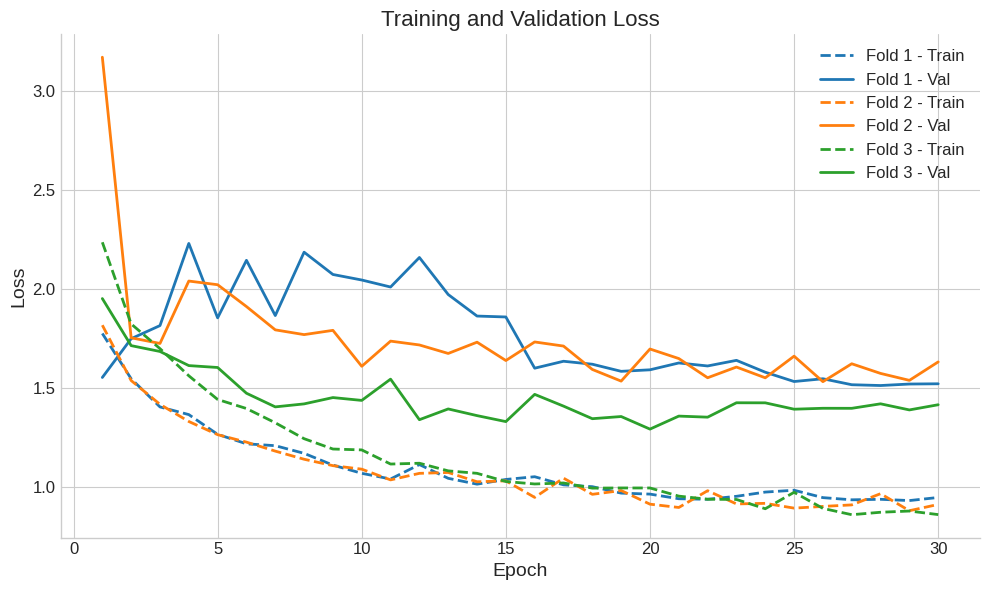

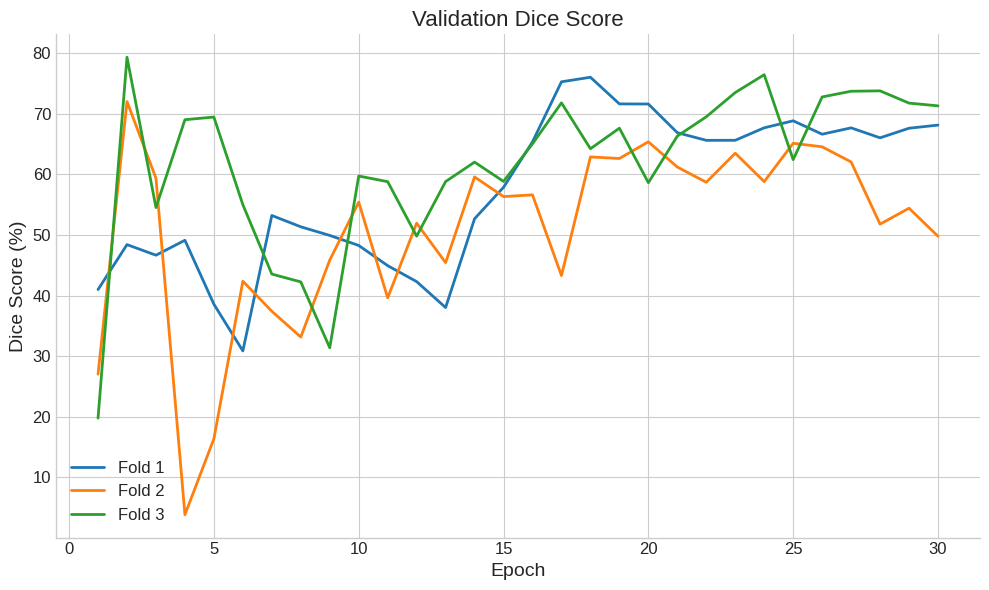

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 100,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 2
})

# Loads CSVs from Drive
folds = {
    "Fold 1": pd.read_csv("/content/drive/MyDrive/fold_1_metrics.csv"),
    "Fold 2": pd.read_csv("/content/drive/MyDrive/fold_2_metrics.csv"),
    "Fold 3": pd.read_csv("/content/drive/MyDrive/fold_3_metrics.csv")
}

colors = plt.get_cmap("tab10")

# --- Plot 1: Training & Validation Loss ---
plt.figure(figsize=(10, 6))
for i, (name, df) in enumerate(folds.items()):
    plt.plot(df["epoch"], df["train_loss"], label=f"{name} - Train", linestyle="--", color=colors(i))
    plt.plot(df["epoch"], df["val_loss"], label=f"{name} - Val", linestyle="-", color=colors(i))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/loss_plot.png", dpi=300)  # Save to Drive
plt.show()

# --- Plot 2: Validation Dice Score ---
plt.figure(figsize=(10, 6))
for i, (name, df) in enumerate(folds.items()):
    plt.plot(df["epoch"], df["val_dice"], label=name, color=colors(i))
plt.title("Validation Dice Score")
plt.xlabel("Epoch")
plt.ylabel("Dice Score (%)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/dice_plot.png", dpi=300)  # Save to Drive
plt.show()
